In [1]:
import torchvision.models as models
import torch
from util.layervisualization import CNNLayerVisualization
from util.modelregressions import CNNCrossFit
from util.misc_functions import float2rgb
from dataset.hvm import HVMDataset
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## Simulated controller

Here the objective was to see if Pouya's original finding (EV =/= strech control) holds even for simulated neural control.
We modified the metric to be strech control with source model vs. with target model. Using hvm data for mapping, range of sample size (200:500:1000:5000), we find qualitatively very similar phenomena. Unclear if using imagenet we will set any difference as a function a sample size. We defer this to a subsequent notebook.

In [2]:
# load up target and source models
squeezenet_target = models.squeezenet1_0(pretrained=True).features.to(device)
squeezenet_source = models.squeezenet1_1(pretrained=True).features.to(device)
#alexnet_source = models.alexnet(pretrained=True).features

C:\Users\Chong Guo\AppData\Local\conda\conda\envs\torch\lib\site-packages\torchvision\models\squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
C:\Users\Chong Guo\AppData\Local\conda\conda\envs\torch\lib\site-packages\torchvision\models\squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)


In [3]:
# define basic params 
cnn_layer = 12
source_units = np.arange(512)
target_units = np.arange(512)
img_dim = [256,256,3]

In [4]:
# pre-load data into memory for speed
hvmdataset = HVMDataset(device,5000)
# create a control experiment (squeezenet1_1-->squeezenet1_0)
snet2snet200 = CNNCrossFit(squeezenet_target,squeezenet_source,cnn_layer,target_units,source_units,device)
# extract layer activation across two models
snet2snet200.design(hvmdataset, batch_size = 1, record_gradient = False)
# linear prediction of target unit, score the training set
snet2snet200.fit(4000,1000)
# score the testset
snet2snet200.score()
# implement source control of target units, record performance
snet2snet200.control()

Extracting activations


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:46<00:00, 107.25it/s]


Linear regression from source to target:


100%|████████████████████████████████████████████████████████████████████████████████| 512/512 [00:48<00:00, 10.87it/s]


Optimizing source to target control:


100%|████████████████████████████████████████████████████████████████████████████████| 512/512 [02:16<00:00,  3.74it/s]


No handles with labels found to put in legend.


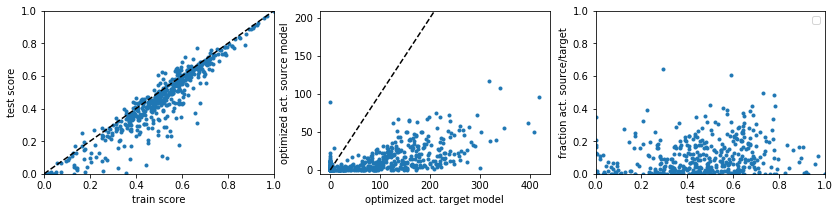

In [5]:
plt.figure(figsize=(14,3))
plt.subplot(1,3,1)
plt.plot(snet2snet200.train_score,snet2snet200.test_score,'.')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim((0,1))
plt.xlabel('train score')
plt.ylabel('test score')
plt.subplot(1,3,2)
plt.plot(snet2snet200.target_act,snet2snet200.source_act,'.')
lmin, lmax = min(snet2snet200.target_act), max(snet2snet200.target_act)
plt.plot([lmin, lmax],[lmin, lmax],'k--')
plt.axis('tight')
plt.ylim((lmin-5,lmax/2))
plt.xlabel('optimized act. target model')
plt.ylabel('optimized act. source model')
plt.subplot(1,3,3)
plt.plot(snet2snet200.test_score,snet2snet200.ctr_score,'.')
plt.legend()
plt.xlim((0,1))
plt.ylim((0,1))
plt.xlabel('test score')
plt.ylabel('fraction act. source/target')
plt.show()

What if the original objective function is just lighting up the network unselectively? To test that we scrambled the linear mapping weight.

In [ ]:
# implement source control of target units, with shuffled mapping.
snet2snet200.score(test_time_scramble=True) 
snet2snet200.control(scramble = True)

No handles with labels found to put in legend.


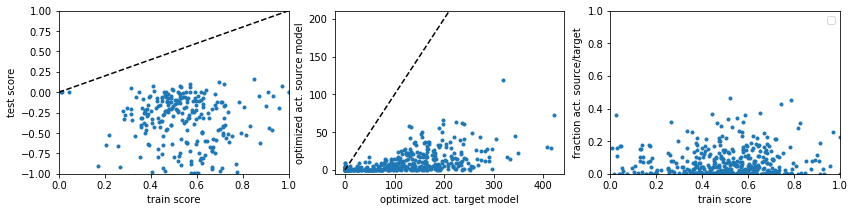

In [13]:
plt.figure(figsize=(14,3))
plt.subplot(1,3,1)
plt.plot(snet2snet200.train_score,snet2snet200.test_score,'.')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim((-1,1))
plt.xlabel('train score')
plt.ylabel('test score')
plt.subplot(1,3,2)
plt.plot(snet2snet200.target_act,snet2snet200.source_act,'.')
lmin, lmax = min(snet2snet200.target_act), max(snet2snet200.target_act)
plt.plot([lmin, lmax],[lmin, lmax],'k--')
plt.axis('tight')
plt.ylim((lmin-5,lmax/2))
plt.xlabel('optimized act. target model')
plt.ylabel('optimized act. source model')
plt.subplot(1,3,3)
plt.plot(snet2snet200.train_score,snet2snet200.ctr_score,'.')
plt.legend()
plt.xlim((0,1))
plt.ylim((0,1))
plt.xlabel('train score')
plt.ylabel('fraction act. source/target')
plt.show()

Unsurprisingly, the test score is down we now have no neural predictbility. But control score is still up. In fact it's almost the same as using non-random weight. 

So while Pouya's original result seems to hold. i.e. EV =/= (stretch) control score. When it does work it's not necessarily that we are using the gradients in a smart way. 

In [7]:
# create two feature visualization objects
img_dim = [256,256,3]
niter = 100
layer_vis_target = CNNLayerVisualization(squeezenet_target, cnn_layer, target_units[0],img_dim, device)

# Image sythesis with pytorch hooks
[Img_target, target_val] = layer_vis_target.visualise_layer_with_hooks(niter=niter)

Iteration: 50 Loss: -474.55
Iteration: 100 Loss: -1135.06


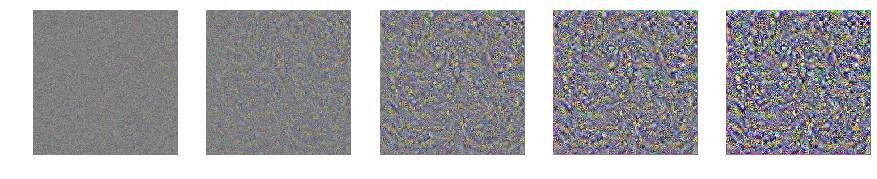

In [8]:
img = np.zeros((img_dim[0]*img_dim[1]*img_dim[2],niter))
plt.figure(figsize=(15,40))
for i in range(niter):
    im_path = 'generated/layer_vis_l' + str(cnn_layer) + \
        '_f' + str(source_units[0]) + '_iter' + str(i+1) + '.jpg'
    tempimg=mpimg.imread(im_path)
    img[:,i] = tempimg.flatten()
    if i%(niter/5) == 0:
        plt.subplot(1,5,round(i/(niter/5))+1)
        plt.imshow(tempimg)
        plt.axis('off')
        plt.clim([0,1])
plt.show()

An interesting observation here is that the image evolved appear to be moving in a single principle direction. And the image moves almost linearly along a principle direction in the gradient space. The PCA analysis below check this intuition (Apear to be more the case for lower layers).

In [9]:
import seaborn as sns
from sklearn.decomposition import PCA

D = img[:,0:-2:1]-img[:,1:-1:1];
[d,n] = D.shape
pca = PCA(n_components=n,whiten=False)
pca.fit(D)

PCA(copy=True, iterated_power='auto', n_components=98, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

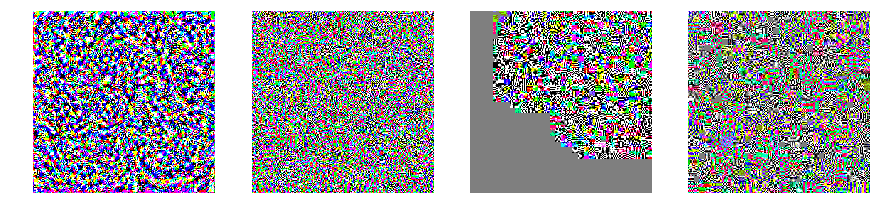

In [10]:
Dpca = pca.transform(D)
Dproj_pc1 = Dpca[:,0].reshape(img_dim)

plt.figure(figsize=(15,40))
plt.subplot(1,4,1)
plt.imshow(float2rgb(tempimg))
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(float2rgb(Dproj_pc1))
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(float2rgb(D[:,5].reshape(img_dim)))
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(float2rgb(D[:,-5].reshape(img_dim)))
plt.axis('off')
plt.show()

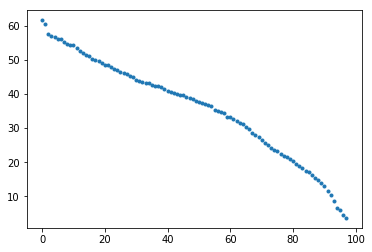

In [11]:
plt.plot(pca.explained_variance_,'.')
plt.show()

This PCA of the gradient vector over all iterations shows a single large eigenvalue (only when using lower layers).